In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

from tqdm import tqdm, trange, tqdm_notebook
from matplotlib.pylab import get_cmap
import warnings
warnings.filterwarnings('ignore')


import numpy as np
import scipy as sp
import sys, os
try:
    import cPickle as pickle
except:
    import pickle
from glob import glob

fs=20
fs_ticks = 16
from scipy.stats import norm

# define sfb colors
colors = ['#3850A1', '#F79645', '#993A91']
#new trial
colors = ['#0D589A', '#5DB5D0', '#A9DBB7','blue']

from matplotlib.ticker import (AutoMinorLocator, FixedLocator, FuncFormatter,
                               MultipleLocator, NullLocator, LogLocator)
import healpy as hp

from scipy.interpolate import UnivariateSpline
from matplotlib.lines import Line2D


from scipy.interpolate import splrep, splev
from copy import deepcopy 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
#from mpl_toolkits.basemap import Basemap
from matplotlib.colors import LogNorm
from PyAstronomy import pyasl

In [7]:
from astropy import units as u
from astropy.coordinates import SkyCoord

In [8]:
from tools import *
from tools import _trans

---
# Get the effective area of Plenum for different declinations and energies
---

In [ ]:
path = "/Users/mhuber/StackingSkylab/MultiYearPointSourceData/"
mc = np.load(os.path.join(path,'IC86-2012_MC.npy'))

In [17]:
E_bins = np.linspace(2.,9.,num=25)
bin_width = np.diff(10**E_bins)
bin_width = np.append(bin_width,np.max(bin_width))
bin_mids = (E_bins[1:] + E_bins[:-1]) * 0.5

#decs = np.arange(-88,88,4)
sdecs = np.linspace(-1.,1.,35)
sdecs_mids = get_mids(sdecs, ext=True)
w_sdecs = np.diff(sdecs)[2] / 2.

h2d = np.zeros((len(sdecs_mids), len(E_bins)-1), dtype=float)
for di, deci in enumerate(sdecs_mids):
    dec_min, dec_max = sdecs[di], sdecs[di+1]  #  deci - w_sdecs, deci + w_sdecs
    
    Omega = 2 * np.pi * (dec_max - dec_min)
    dec_mask = (np.sin(mc['trueDec']) > dec_min)&(np.sin(mc['trueDec']) < dec_max)

    ind = np.searchsorted(E_bins, np.log10(mc['trueE'][dec_mask])) - 1 
    Aeff = (mc['ow'])[dec_mask] / Omega / bin_width[ind] # * mc['trueE'][dec_mask]**(-2.)

    h = np.histogram(np.log10(mc['trueE'][dec_mask]),bins=E_bins, weights=Aeff)[0]
    
    h2d[di] = h



In [18]:
#h2d[h2d<1e-2] = 0.

fig,ax=plt.subplots()
p = ax.pcolormesh(E_bins,sdecs,  h2d *1e4 , norm=LogNorm(),#, vmin=1e-2)#, 
                  vmax = 1e12, vmin=1e-2)

fig.colorbar(p,ax=ax)


ax.set_xlabel(r'$\log_{10}$(true Energy/GeV)',fontsize=12)
ax.set_ylabel(r'sin(dec)',fontsize=12)


fig.tight_layout()
plt.show()

<IPython.core.display.Javascript object>

# Get a spline representation along each sin(dec) bin

In [19]:
from scipy.interpolate import RegularGridInterpolator
fig, ax = plt.subplots(figsize=(7,6))


grid2d = RegularGridInterpolator((sdecs_mids, bin_mids), h2d, method='linear', 
                                 bounds_error=False, fill_value=0.)

tcks_effA = dict()
xvals = np.linspace(-1,1,100)

for ei, evali in enumerate(bin_mids):

    tcki = splrep(sdecs_mids, h2d[:,ei], s=1.e-4)
    spl_val = splev(xvals, tcki)
    p=ax.plot(sdecs_mids, h2d[:,ei],  ls='solid', alpha=0.5)
    
    
    ax.plot(xvals, grid2d(( xvals, evali)), color=p[0].get_color(), ls='dotted')
    tcks_effA[evali] = tcki

ax.set_yscale('log')
fig.tight_layout()

<IPython.core.display.Javascript object>

# Get the effective area of plenum now

In [ ]:
fact = 1.
poles = {'IceCube':(np.radians(0), np.radians(-90.)),
         #'Gen2':(np.radians(0), np.radians(-90.)),
         'P-ONE':(-np.radians(123.3656), np.radians(48.4284)),
         'KM3NeT':(np.radians(16.1), np.radians(36.27)) ,
         'Baikal-GVD':(np.radians(108.1650), np.radians(53.5587)),
         #'X, China':(np.radians(111.918), np.radians(8.640)),
         #'SA, Cape Town ':(np.radians(18.4241), np.radians(-33.9249)),
        #'hypothetical':(np.radians(0.2093), np.radians(-0.8688)),
        }
      
comb_values_effA = dict()


for ei, evali in tqdm(enumerate(bin_mids)):
    comb_values_i = dict()
    for i,(name, new_pole) in enumerate(sorted(poles.iteritems())):    

        vals = np.zeros(npix)    
        rot_angles = np.arange(0.,360., 15.) #15.
        for rot_ra in rot_angles:
            vals2 = np.zeros(npix)
            new_ra = new_pole[0] + np.radians(rot_ra)

            x = np.linspace(0,2*np.pi, 1.e3)
            y = np.linspace(-np.pi/2,np.pi/2 ,500)

            xx, yy = np.meshgrid(x,y,indexing='ij')

            ra2 , dec2 = rotate(0, -np.pi/2, new_ra, new_pole[1],xx.ravel(),yy.ravel())


            lat2 = np.pi/2 + dec2
            lat2 = lat2
            lon2, lat2 = _trans(ra2, lat2)

            p = hp.ang2pix(NSIDE, lat2, lon2)

            #tcki = tcks[Ethi]
            
            vals2[p] = grid2d((np.sin(yy.ravel()), evali)) #splev(yy.ravel(), tcki)
            

            if name == 'Gen2':
                vals2 *= 7.5

            vals = vals + vals2 * (1. / len(rot_angles))

            
        comb_values_i[name] = vals
        
    comb_values_effA[evali] = comb_values_i
blub = 5000

22it [37:31, 102.33s/it]

# Now extract plenum and icecube information and remove the right ascension dimension

In [360]:
x = np.linspace(-np.pi, np.pi, ngrid)
y = np.linspace( 0, np.pi, ngrid / 2)
       
lon = np.linspace(-np.pi, np.pi, len(x))
lat = np.linspace(-np.pi/2., np.pi/2., len(y))

xx,yy = np.meshgrid(lon,lat)

bins = deepcopy(sdecs)# np.linspace(-1,1, 20) #50
inds = np.searchsorted( bins, np.sin(yy.flatten()))

Res_effA = np.zeros((len(bins)-1, len(bin_mids)),
                   dtype=float)

Res_effA_icecube = np.zeros((len(bins)-1, len(bin_mids)),
                   dtype=float)


av_values = deepcopy(comb_values_effA)

for ei, (evali, vals) in enumerate(sorted(av_values.iteritems())):
    
    
    vals_tot = np.zeros(npix)
    for (name, vali) in vals.iteritems():
        vals_tot += vali
    
    zval = plot_area(vals_tot, None, npix=ngrid,  
              donot_plot=True)#, norm=LogNorm())

    zval = zval.flatten()
    
    res = np.zeros_like(get_mids(bins))
    for i, indi in enumerate(get_mids(bins)):
        m = inds==i
        res[i] = np.sum(zval[m]) / float(np.sum(m))
       
    Res_effA[:,ei] = res



    
av_values = deepcopy(comb_values_effA)

for ei, (evali, vals) in enumerate(sorted(av_values.iteritems())):
    
    
    vals_tot = np.zeros(npix)
    for (name, vali) in vals.iteritems():
        if name != 'IceCube':
            continue
        vals_tot += vali
    
    zval = plot_area(vals_tot, None, npix=ngrid,  
              donot_plot=True)#, norm=LogNorm())

    zval = zval.flatten()
    
    res = np.zeros_like(get_mids(bins))
    for i, indi in enumerate(get_mids(bins)):
        m = inds==i
        res[i] = np.sum(zval[m]) / float(np.sum(m))
       
    Res_effA_icecube[:,ei] = res

(0, 1793701.8052769857)
(1, 16160204.479731927)
(2, 80315177.3568431)
(3, 308421340.2782204)
(4, 1008748200.0182076)
(5, 2880744668.5961747)
(6, 7179583382.583984)
(7, 16038673579.988268)
(8, 31905471900.73335)
(9, 57719410959.341156)
(10, 97370576528.02037)
(11, 155947424327.01776)
(12, 241426448765.0619)
(13, 360000556592.1133)
(14, 520604522021.72174)
(15, 723396086194.2753)
(16, 996722813796.8612)
(17, 1342391931377.5525)
(18, 1784818115530.077)
(19, 2287281141532.67)
(20, 2968435136203.2925)
(21, 3871448246412.8086)
(22, 4815924450261.902)
(23, 6031467571490.747)
(0, 447571.7953768602)
(1, 4032449.495567088)
(2, 20042286.151121493)
(3, 76965889.105409)
(4, 251732802.91684094)
(5, 718929669.7642121)
(6, 1791804005.8926942)
(7, 4002711194.434915)
(8, 7962371823.716868)
(9, 14405455217.743397)
(10, 24304172074.85437)
(11, 38933422811.036545)
(12, 60293308872.8538)
(13, 89953616551.98685)
(14, 130135385933.8527)
(15, 180902556601.0176)
(16, 249336882568.92096)
(17, 335906955975.5236)


<IPython.core.display.Javascript object>


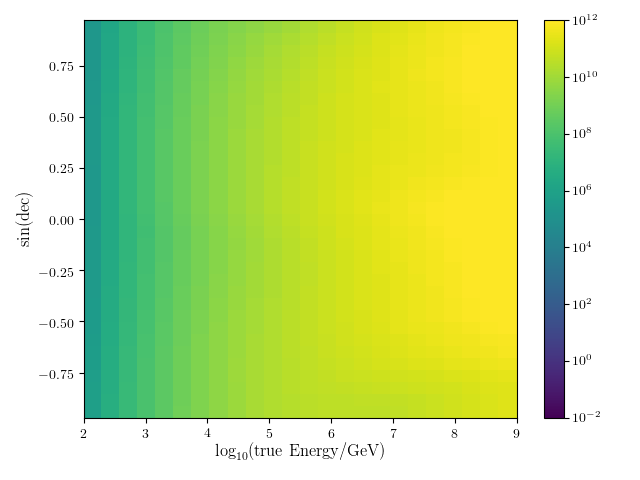

In [345]:
fig,ax=plt.subplots()
p = ax.pcolormesh(E_bins, get_mids(bins),  Res_effA*1e4  , norm=LogNorm(),#, vmin=1e-2)#, 
                  vmax = 1e12, vmin=1e-2)

fig.colorbar(p,ax=ax)


ax.set_xlabel(r'$\log_{10}$(true Energy/GeV)',fontsize=12)
ax.set_ylabel(r'sin(dec)',fontsize=12)


fig.tight_layout()
plt.show()

In [373]:
fig, ax = plt.subplots()
results = np.zeros((len(Res_effA.flatten()),), 
                   dtype=[('sinDec',float), ('logE', float), ('effA_icecube', float),
                         ('effA_plenum', float)])
results['sinDec'] = np.tile(sdecs_mids, len(bin_mids))
results['logE'] = np.repeat(bin_mids, len(sdecs_mids))
results['effA_plenum'] = Res_effA.flatten()
results['effA_icecube'] = Res_effA_icecube.flatten()

l_sd = len(sdecs_mids)
for ei, evali in enumerate(bin_mids):
    #print len(bins), len()
    #results['sinDec'][ei*l_sd:(ei+1)*l_sd] = sdecs_mids
    #results['logE'][ei*l_sd:(ei+1)*l_sd] = evali
    #results['effA_plenum'][ei*l_sd:(ei+1)*l_sd] = Res_effA[:,ei]
    #results['effA_icecube'][ei*l_sd:(ei+1)*l_sd] = grid2d(( sdecs_mids, evali))
    
    p=ax.plot(sdecs_mids,  Res_effA_icecube[:,ei], alpha=0.5)
    ax.plot(xvals, grid2d(( xvals, evali)), color=p[0].get_color(), ls='dotted')
ax.set_yscale('log')
fig.tight_layout()

#np.save('resources/effective_areas_av_per_day.npy', results)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


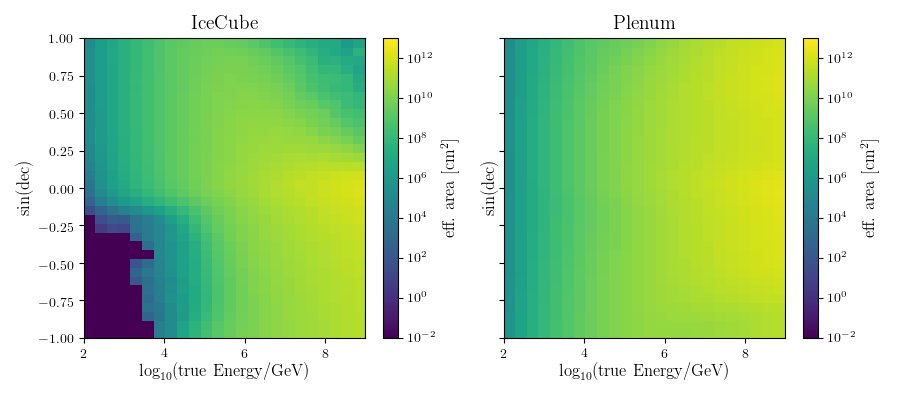

In [370]:
n_sd, n_e =  np.unique(e_vals, return_counts=True)
n_sd, n_e = len(n_sd), n_e[0]

e_bins = np.linspace(2.,9.,num=25)
sd_bins = np.linspace(-1.,1.,35)

fig, axes=plt.subplots(ncols=2, figsize=(9,4), sharey=True)

ax = axes[0]
ax.set_title('IceCube', fontsize=14)
p = ax.pcolormesh(e_bins, sd_bins, #Res_effA*1e4
                  results['effA_icecube'].reshape((n_e, n_sd))*1e4  
                  , norm=LogNorm(),#, vmin=1e-2)#, 
                  vmax = 1e13, vmin=1e-2)

ax.set_xlabel(r'$\log_{10}$(true Energy/GeV)',fontsize=12)
ax.set_ylabel(r'sin(dec)',fontsize=12)

cb=fig.colorbar(p,ax=ax)
cb.set_label(r'eff. area [cm$^2$]', fontsize=12)

ax = axes[1]
ax.set_title('Plenum', fontsize=14)
p = ax.pcolormesh(e_bins, sd_bins,
                  results['effA_plenum'].reshape((n_e, n_sd))*1e4  
                  , norm=LogNorm(),#, vmin=1e-2)#, 
                  vmax = 1e13, vmin=1e-2)

ax.set_xlabel(r'$\log_{10}$(true Energy/GeV)',fontsize=12)
ax.set_ylabel(r'sin(dec)',fontsize=12)

cb=fig.colorbar(p,ax=ax)
cb.set_label(r'eff. area [cm$^2$]', fontsize=12)

fig.tight_layout()
plt.show()